<a href="https://colab.research.google.com/github/dgatti/PortfolioBigData/blob/main/SegmentacionDepartamentoMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Se cuenta con un set de datos de clientes de un banco y para una campaña de ventas de Marketing se requiere segmentar a los clientes en función de dichos datos**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_banco=pd.read_csv('/content/drive/MyDrive/DataSciencieICES/Marketing_data.csv')
# CUSTID: Identificación del titular de la tarjeta de crédito
# BALANCE: Cantidad de saldo que queda en la cuenta del cliente para hacer compras
# BALANCE_FREQUENCY: Frecuencia de la actualización del saldo, puntuación entre 0 y 1 (1 = actualizado con frecuencia, 0 = no actualizado con frecuencia)
# PURCHASES: Cantidad de compras realizadas desde la cuenta
# ONEOFFPURCHASES: Importe máximo de compra realizado en una sola vez
# INSTALLMENTS_PURCHASES: Importe de la compra realizada en cuotas
# CASH_ADVANCE: Anticipo otorgado al usuario
# PURCHASES_FREQUENCY: frecuencia con la que se realizan las compras, puntuación entre 0 y 1 (1 = compras frecuentes, 0 = compras no frecuentes)
# PURCHASES_FREQUENCY: Frecuencia de las Compras se están realizando, puntuación entre 0 y 1 (1 = compra con frecuencia, 0 = no compra con frecuencia)
# ONEOFF_PURCHASES_FREQUENCY: Con qué frecuencia las compras se realizan de una sola vez (1 = compra con frecuencia, 0 = no compra con frecuencia)
# PURCHASES_INSTALLMENTS_FREQUENCY: Con qué frecuencia se realizan las compras a plazos (1 = se realizan con frecuencia, 0 = no se realizan con frecuencia)
# CASH_ADVANCE_FREQUENCY: con qué frecuencia el gasto se paga por adelantado
# CASH_ADVANCE_TRX: número de transacciones realizadas con "Efectivo por adelantado"
# PURCHASES_TRX: número de transacciones de compras realizadas
# CREDIT_LIMIT: límite de tarjeta de crédito para el usuario
# PAYMENTS: Número de pagos realizados por el usuario
# MINIMUM_PAYMENTS: cantidad mínima de pagos realizados por el usuario
# PRC_FULL_PAYMENT: porcentaje del pago total pagado por el usuario
# TENURE: Años que el usuario lleva usando el servicio de tarjeta de crédito

In [ ]:
df_banco.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900.749,818.182,95.40,0.00,95.40,0,166.667,0.000,83.333,0,0,2,1000,201.802.084,139.509.787,0.000,12
1,C10002,3.202.467.416,909.091,0.00,0.00,0.00,6.442.945.483,0.000,0.000,0.000,0.25,4,0,7000,4.103.032.597,1.072.340.217,222.222,12
2,C10003,2.495.148.862,1.000,773.17,773.17,0.00,0,1.000,1.000,0.000,0,0,12,7500,622.066.742,627.284.787,0.000,12
3,C10004,1.666.670.542,636.364,1499.00,1499.00,0.00,205.788.017,83.333,83.333,0.000,83.333,1,1,7500,0,NaN,0.000,12
4,C10005,817.714.335,1.000,16.00,16.00,0.00,0,83.333,83.333,0.000,0,0,1,1200,678.334.763,244.791.237,0.000,12
5,C10006,1.809.828.751,1.000,1333.28,0.00,1333.28,0,666.667,0.000,583.333,0,0,8,1800,140.005.777,2.407.246.035,0.000,12
6,C10007,627.260.806,1.000,7091.01,6402.63,688.38,0,1.000,1.000,1.000,0,0,64,13500,6.354.314.328,198.065.894,1.000,12
7,C10008,1.823.652.743,1.000,436.20,0.00,436.20,0,1.000,0.000,1.000,0,0,12,2300,679.065.082,53.203.399,0.000,12
8,C10009,1.014.926.473,1.000,861.49,661.49,200.00,0,333.333,83.333,0.250,0,0,5,7000,688.278.568,311.963.409,0.000,12
9,C10010,152.225.975,545.455,1281.60,1281.60,0.00,0,166.667,166.667,0.000,0,0,3,11000,1.164.770.591,100.302.262,0.000,12


In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   object 
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   object 
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   object 
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [ ]:
df_banco.describe()
# El balance medio es $1564 
# La frecuencia del balance se actualiza bastante a menudo, en promedio ~0.9
# El promedio de las compras es $1000
# El importe máximo de compra no recurrente es en promedio ~$600
# El promedio de la frecuencia de las compras está cerca de 0.5
# El promedio de ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, y CASH_ADVANCE_FREQUENCY es en general bajo
# El promedio del límite de crédito es ~ 4500
# El porcentaje de pago completo es 15%
# Los clientes llevan de promedio en el servicio 11 años

,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,170.352653,1003.204834,592.437371,411.067645,184.165420,109.266052,160.953878,3.248827,14.709832,67.008146,11.517318
std,304.671595,2136.634782,1659.887917,904.338115,296.249371,211.346748,288.164391,6.824647,24.857649,182.269536,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,1.000000,39.635000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000
50%,1.000000,361.280000,38.000000,89.000000,1.000000,0.250000,0.500000,0.000000,7.000000,0.000000,12.000000
75%,181.818000,1110.130000,577.405000,468.637500,333.333000,83.333000,166.667000,4.000000,17.000000,1.000000,12.000000
max,909.091000,49039.570000,40761.250000,22500.000000,916.667000,916.667000,916.667000,123.000000,358.000000,916.667000,12.000000


In [ ]:
#Datos de la instancia o registro asociado a ese valor de compra
df_banco[df_banco['ONEOFF_PURCHASES']==40761.25]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
550,C10574,1.154.752.001,1.0,49039.57,40761.25,8278.32,558.166.886,1.0,1.0,916.667,83.333,1,101,22500,4.693.059.824,2.974.069.421,0.25,12


In [ ]:
df_banco['CASH_ADVANCE'].max()

'998.896.759'

In [ ]:
# Vamos a ver quien pago por anticipado $998.896.759!
# Este cliente hizo un total de 123 transacciones por adelantado!!
# Nunca paga sus compras completamente con la tarjeta

df_banco[df_banco['CASH_ADVANCE'] == '998.896.759']

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
8206,C18426,974.749.857,1.0,0.0,0.0,0.0,998.896.759,0.0,0.0,0.0,416.667,5,0,1200,1.274.705.644,27.905.917,0.0,12


**Visualizacion del DataSet**

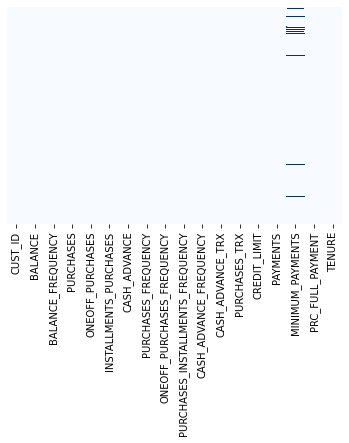

In [ ]:
sns.heatmap(df_banco.isnull(), yticklabels=False, cbar=False, cmap="Blues")

In [ ]:
df_banco.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [ ]:
#Las columnas con las que se va a trabajar son del tipo Object por los que previamente se requiere convertir sus datos a float.
#Para esto, previamente se debe reemplzar el . para dejar el object en "formato" numerico y luego los valores NaN convertirlos a 0
#De esa forma la conversión no da error
df_banco['MINIMUM_PAYMENTS']=df_banco['MINIMUM_PAYMENTS'].str.replace('.','')
df_banco['MINIMUM_PAYMENTS']=df_banco['MINIMUM_PAYMENTS'].replace(np.nan, 0, regex=True)
df_banco['MINIMUM_PAYMENTS']=pd.to_numeric(df_banco['MINIMUM_PAYMENTS'], downcast="float")

In [ ]:
#Rellenamos los datos faltantes (0) con la media de la columna
df_banco.loc[(df_banco['MINIMUM_PAYMENTS'] == 0), 'MINIMUM_PAYMENTS'] = df_banco['MINIMUM_PAYMENTS'].mean()
df_banco['MINIMUM_PAYMENTS']

0       1.395098e+08
1       1.072340e+09
2       6.272848e+08
3       6.211902e+08
4       2.447912e+08
            ...     
8945    4.888636e+07
8946    6.211902e+08
8947    8.241837e+07
8948    5.575563e+07
8949    8.828896e+07
Name: MINIMUM_PAYMENTS, Length: 8950, dtype: float32

In [ ]:
df_banco['CREDIT_LIMIT']=df_banco['CREDIT_LIMIT'].str.replace('.','')
df_banco['CREDIT_LIMIT']=df_banco['CREDIT_LIMIT'].replace(np.nan, 0, regex=True)
df_banco['CREDIT_LIMIT']=pd.to_numeric(df_banco['CREDIT_LIMIT'], downcast="float")

In [ ]:
df_banco.loc[(df_banco['CREDIT_LIMIT'] == 0), 'CREDIT_LIMIT'] = df_banco['CREDIT_LIMIT'].mean()
df_banco['CREDIT_LIMIT']

0       1000.0
1       7000.0
2       7500.0
3       7500.0
4       1200.0
         ...  
8945    1000.0
8946    1000.0
8947    1000.0
8948     500.0
8949    1200.0
Name: CREDIT_LIMIT, Length: 8950, dtype: float32

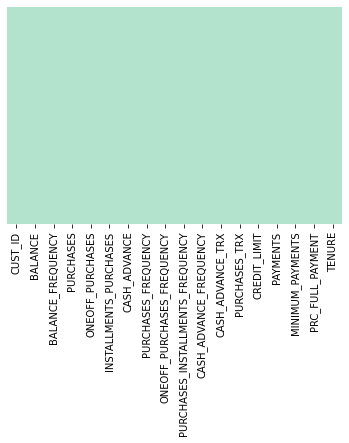

In [ ]:
#volvemos a revisar si quedaron valores null
sns.heatmap(df_banco.isnull(), yticklabels=False, cbar=False, cmap="Pastel2")

In [ ]:
df_banco.duplicated().sum()

0

In [ ]:
df_banco.drop('CUST_ID', axis=1, inplace=True)

In [ ]:
n = len(df_banco.columns)

In [ ]:
df_banco.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   object 
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   object 
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   object 
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [ ]:
df_banco['BALANCE']=df_banco['BALANCE'].str.replace('.','')
df_banco['CASH_ADVANCE']=df_banco['CASH_ADVANCE'].str.replace('.','')
df_banco['CASH_ADVANCE_FREQUENCY']=df_banco['CASH_ADVANCE_FREQUENCY'].str.replace('.','')
df_banco['PAYMENTS']=df_banco['PAYMENTS'].str.replace('.','')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

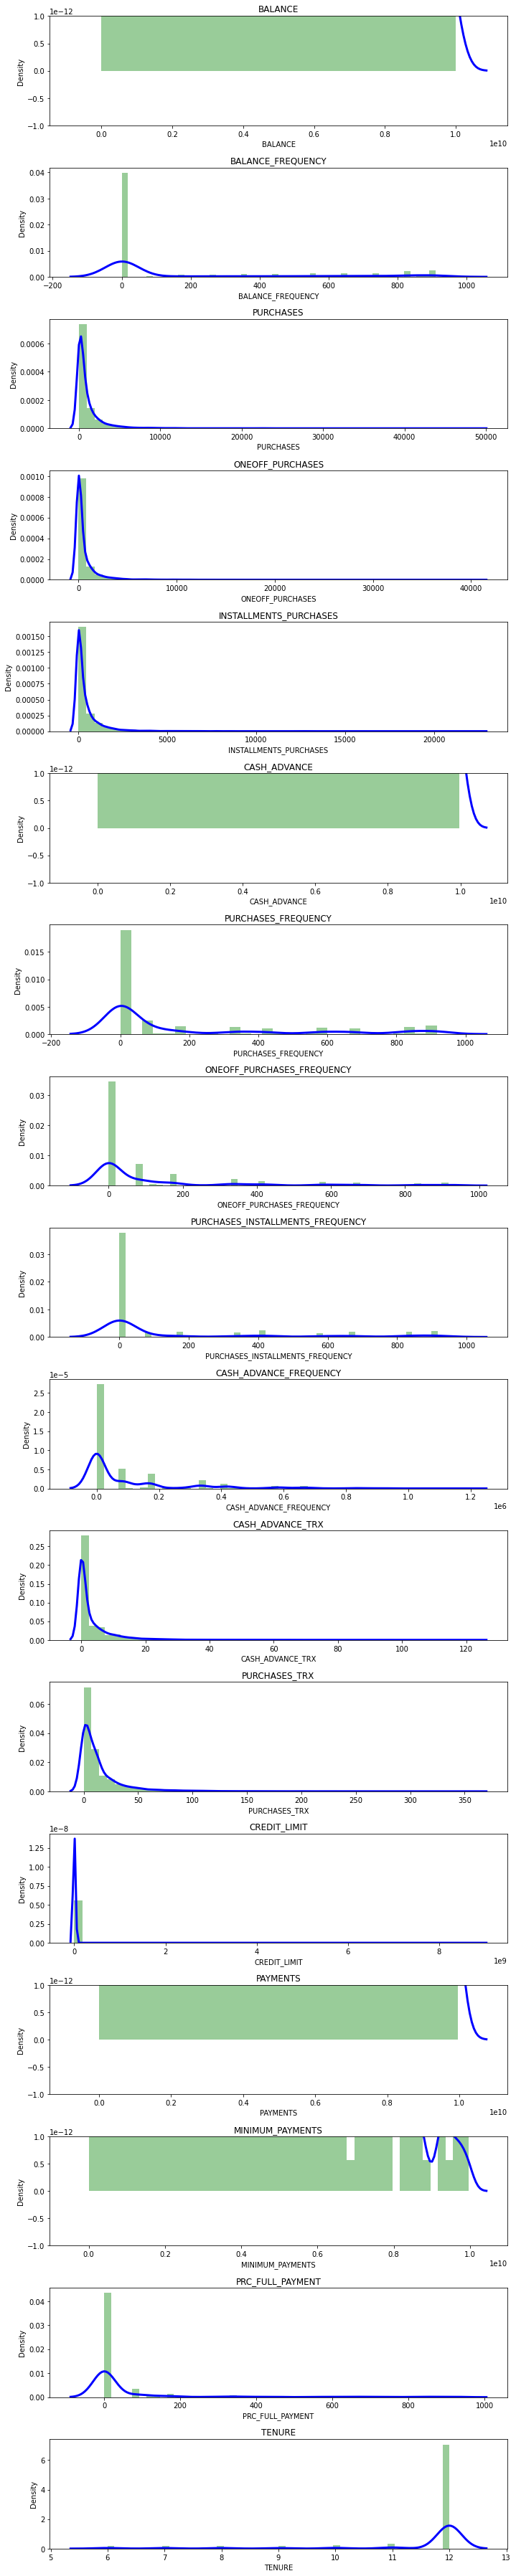

In [ ]:
# distplot combina la función matplotlib.hist con la de seaborn kdeplot()
# KDE Plot representa la Kernel Density Estimate
# KDE se utiliza para visualizar la densidad de una probabilidad de una variable continua. 
# KDE nos muestra la densidad de una probabilidad para diferentes valores de una variable continua. 

#EJEMPLO DE LO QUE SE PUEDE OBTENER DE ESTOS GRÁFICOS DE DENSIDAD DE PROBABILIDAD.
# El balance promedio es  $1500
# 'Balance_Frequency' para muchos usuarios se actualiza muy frecuentemente ~1
# Para el campo 'PURCHASES_FREQUENCY', hay dos grupos diferentes de clientes
# Para los campos 'ONEOFF_PURCHASES_FREQUENCY' y 'PURCHASES_INSTALLMENT_FREQUENCY' la gran mayoría de usuarios no pagan todo de golpe ni a plazos
# Muy pocos clientes pagan su deuda al completo 'PRC_FULL_PAYMENT'~0
# El promedio del límite del crédito está entorno de los $4500
# La mayoría de clientes llevan ~11 años usando el servicio

plt.figure(figsize=(10,50))
for i in range(n):
      plt.subplot(n, 1, i+1)
      sns.distplot(df_banco[df_banco.columns[i]], kde_kws = {"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
      plt.title(df_banco.columns[i])

plt.tight_layout()

In [ ]:
correlation=df_banco.corr()

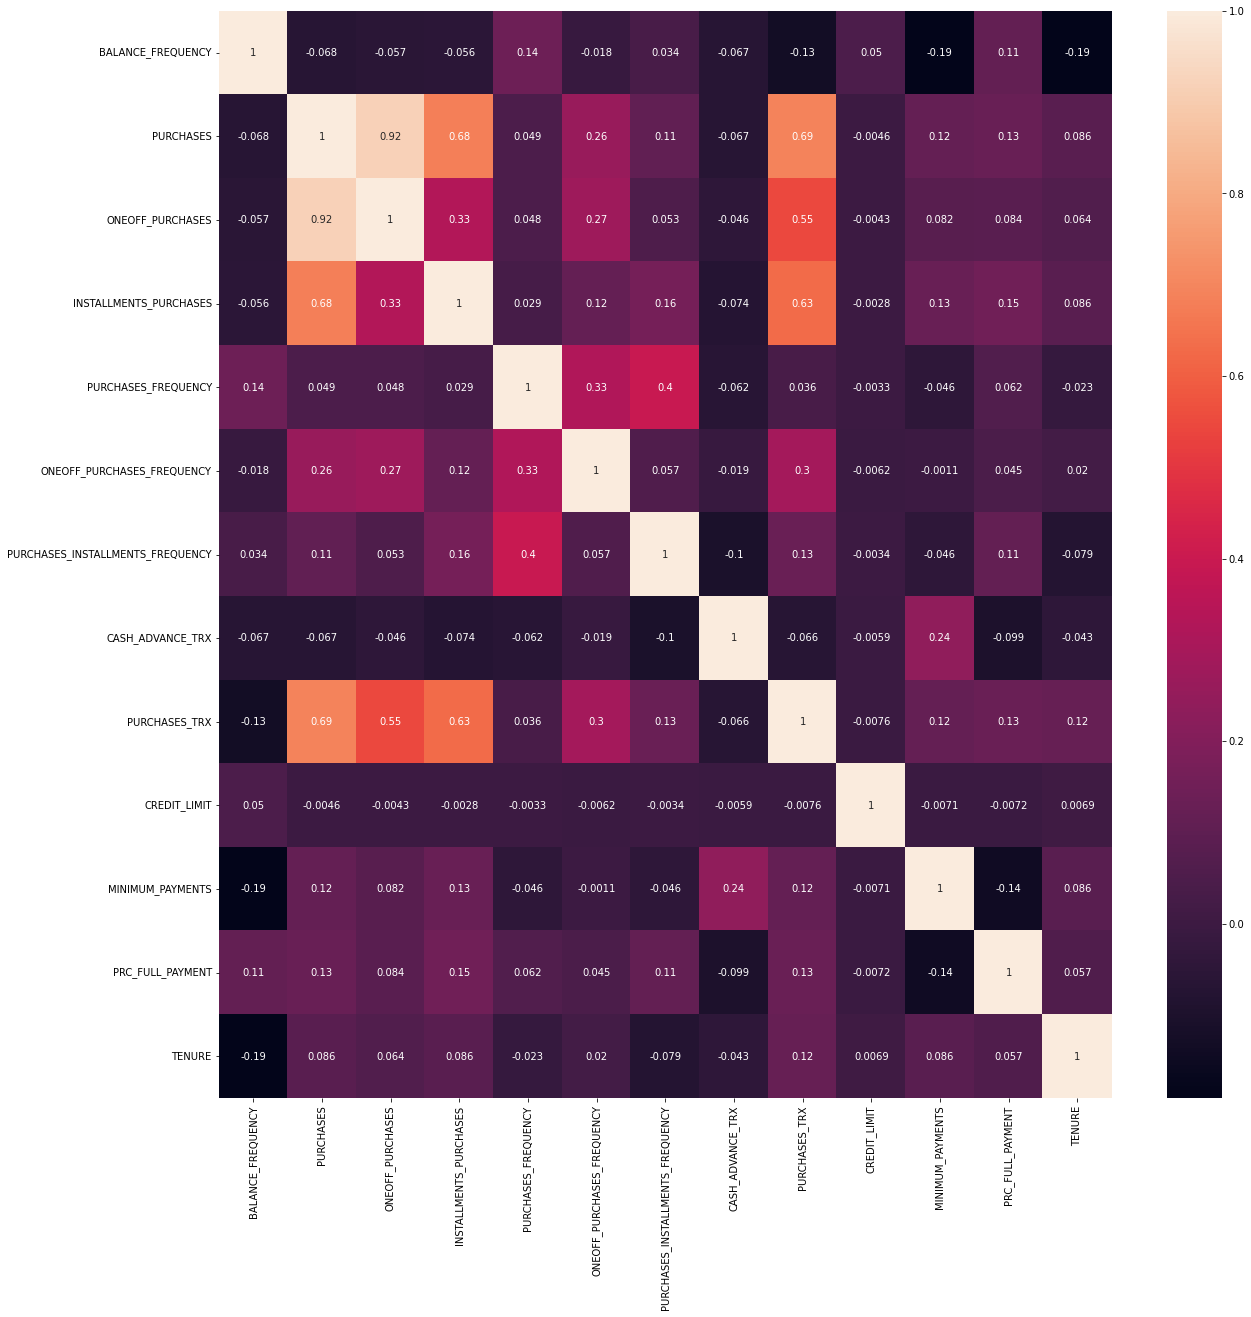

In [ ]:
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlation, annot=True)

## **Aplicar modelo de aprendizaje no supervizado. Meotdo del codo. Segmentación**

El método del codo es un método heurístico de interpretación y validación de la coherencia dentro del análisis de clustering diseñado para ayudar a encontrar el número apropiado de clusters en un conjunto de datos.
Si el gráfico de líneas se parece a un brazo, entonces el "codo" en el brazo es el valor de k que es el mejor.
Source:
https://en.wikipedia.org/wiki/Elbow_method_(clustering)
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [ ]:
#Escalar el dataset
scaler = StandardScaler()
df_banco_scaler = scaler.fit_transform(df_banco)
df_banco_scaler

array([[-0.72948882,  2.12643894, -0.42489974, ..., -0.51465939,
        -0.36765271,  0.36067954],
       [ 1.02616379,  2.42483918, -0.46955188, ...,  0.43902424,
         0.85160982,  0.36067954],
       [ 0.63338204, -0.55588416, -0.10766823, ..., -0.01598029,
        -0.36765271,  0.36067954],
       ...,
       [-0.73920792,  2.17617067, -0.40196519, ..., -0.57302708,
        -0.36628104, -4.12276757],
       [-0.74472833,  2.17617067, -0.46955188, ..., -0.60028586,
        -0.36628104, -4.12276757],
       [-0.54523258,  1.62910519,  0.04214581, ..., -0.56702525,
        -0.36765271, -4.12276757]])

## **StandardScaler**

La idea detrás de StandardScaler es que transformará sus datos de manera que su distribución tenga un valor medio 0 y una desviación estándar de 1. Dada la distribución de los datos, cada valor en el conjunto de datos tendrá el valor medio de la muestra restado , y luego dividido por la desviación estándar de todo el conjunto de datos.

La idea principal es normalizar/estandarizar (mean = 0 y standard deviation = 1) sus características antes de aplicar técnicas de aprendizaje automático.

Una cosa importante que debe tener en cuenta es que la mayoría (si no todos) scikit-learn modelos/clases/funciones, esperan como entrada una matriz X con dimensiones/forma [number_of_samples, number_of_features]. Esto es muy importante. Algunas otras bibliotecas esperan como entrada el inverso.

StandardScaler() normalizará las características (cada columna de X, INDIVIDUALMENTE !!!) para que cada columna/característica/variable tenga mean = 0 y standard deviation = 1.

In [ ]:
df_banco_scaler.shape

(8950, 17)

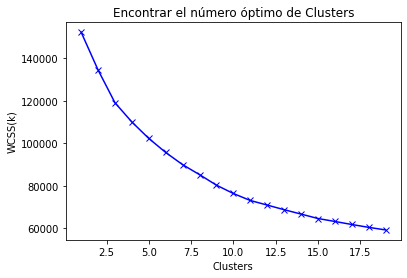

In [ ]:
scores_1=[]
range_values = range(1,20) #Probar kmeans hasta con un maximo de 20 segmentos en busca de la cantidad de segmentos ideales

for i in range_values:
  kmeans=KMeans(n_clusters=i)
  kmeans.fit(df_banco_scaler)
  scores_1.append(kmeans.inertia_) #WCSS

plt.plot(range_values, scores_1, 'bx-')
plt.title("Encontrar el número óptimo de Clusters")
plt.xlabel("Clusters")
plt.ylabel("WCSS(k)")
plt.show()

# Con el gráfico podemos ver que en 4 clusters es donde se forma el codo de la curva.
# Sin embargo, los valores no se reducen a una forma lineal hasta el 8º cluster. 
# Elijamos pues un número de clusters igual a 8, donde se empieza a estabilizar la curva. de todos modos se peude ir jugando con un margen +/-2

## **Aplicar el metodo K-Means**

In [ ]:
kmeans=KMeans(8)
kmeans.fit(df_banco_scaler)
label=kmeans.labels_

In [ ]:
kmeans.cluster_centers_.shape #array de 8 centroides de 17 dimensiones

(8, 17)

In [ ]:
cluster_df=pd.DataFrame(kmeans.cluster_centers_)
cluster_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.686899,0.427112,0.136155,-0.003468,0.327900,-0.481787,0.178555,0.057677,0.405910,-0.504045,-0.456782,0.219009,-0.028689,-0.064349,-0.492015,3.330272,0.181724
1,-0.309947,0.669634,-0.279277,-0.202965,-0.287130,0.122725,0.088153,-0.048761,0.234810,0.222782,0.009523,-0.383390,-0.008265,-0.462163,-0.319378,-0.281467,-3.148886
2,-0.275697,0.137005,-0.015876,-0.053141,0.060236,-0.374718,1.412123,0.440300,1.113681,-0.337103,-0.308891,0.061298,-0.028694,-0.156648,-0.186832,-0.178698,0.275676
3,-0.256365,-0.066989,-0.274466,-0.213510,-0.256665,-0.262669,-0.429695,-0.301885,-0.425700,-0.205336,-0.227891,-0.296690,-0.026117,-0.294324,-0.166921,-0.260242,0.268578
4,0.908731,-0.316651,7.563483,6.836839,5.320704,-0.284521,-0.278173,0.407148,0.257529,-0.340262,-0.098379,5.021889,-0.028643,1.201252,0.929915,0.658612,0.329106
5,-0.413539,1.828038,-0.143875,-0.188181,0.005142,-0.337644,0.062576,-0.234696,0.103075,-0.468738,-0.203932,-0.195230,33.152386,0.497340,-0.262561,-0.170446,0.360680
6,1.354468,-0.265399,-0.261918,-0.193198,-0.264512,1.691069,-0.256606,-0.179005,-0.294116,1.441194,1.511384,-0.306913,-0.028676,0.664143,0.883421,-0.227942,0.162735
7,0.540516,-0.383857,1.511363,1.220804,1.330670,-0.226923,-0.204912,1.123921,0.103119,-0.292875,-0.201521,1.843442,-0.028673,1.310256,0.475482,-0.048009,0.313452


In [ ]:
cluster_center=pd.DataFrame(data=kmeans.cluster_centers_, columns=(df_banco.columns))
cluster_center

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.686899,0.427112,0.136155,-0.003468,0.327900,-0.481787,0.178555,0.057677,0.405910,-0.504045,-0.456782,0.219009,-0.028689,-0.064349,-0.492015,3.330272,0.181724
1,-0.309947,0.669634,-0.279277,-0.202965,-0.287130,0.122725,0.088153,-0.048761,0.234810,0.222782,0.009523,-0.383390,-0.008265,-0.462163,-0.319378,-0.281467,-3.148886
2,-0.275697,0.137005,-0.015876,-0.053141,0.060236,-0.374718,1.412123,0.440300,1.113681,-0.337103,-0.308891,0.061298,-0.028694,-0.156648,-0.186832,-0.178698,0.275676
3,-0.256365,-0.066989,-0.274466,-0.213510,-0.256665,-0.262669,-0.429695,-0.301885,-0.425700,-0.205336,-0.227891,-0.296690,-0.026117,-0.294324,-0.166921,-0.260242,0.268578
4,0.908731,-0.316651,7.563483,6.836839,5.320704,-0.284521,-0.278173,0.407148,0.257529,-0.340262,-0.098379,5.021889,-0.028643,1.201252,0.929915,0.658612,0.329106
5,-0.413539,1.828038,-0.143875,-0.188181,0.005142,-0.337644,0.062576,-0.234696,0.103075,-0.468738,-0.203932,-0.195230,33.152386,0.497340,-0.262561,-0.170446,0.360680
6,1.354468,-0.265399,-0.261918,-0.193198,-0.264512,1.691069,-0.256606,-0.179005,-0.294116,1.441194,1.511384,-0.306913,-0.028676,0.664143,0.883421,-0.227942,0.162735
7,0.540516,-0.383857,1.511363,1.220804,1.330670,-0.226923,-0.204912,1.123921,0.103119,-0.292875,-0.201521,1.843442,-0.028673,1.310256,0.475482,-0.048009,0.313452


In [ ]:
# Para entender mejor estos valores, vamos a aplicar la transformación inversa.
cluster_center = scaler.inverse_transform(cluster_center)
cluster_center = pd.DataFrame(data = cluster_center, columns=[df_banco.columns])
cluster_center

# Primer Cluster de Clientes (Transactors): Esos son los clientes que pagan la menor cantidad de cargos por intereses y tienen cuidado con su dinero, Clúster con el saldo más bajo ($ 104) y anticipo en efectivo ($ 303), Porcentaje de pago completo = 23%
# Segundo Cluster de Clientes (Revolvers) que usan tarjeta de crédito como préstamo (sector más lucrativo): saldo más alto ($ 5000) y anticipo en efectivo (~ $ 5000), baja frecuencia de compra, alta frecuencia de anticipo en efectivo (0.5), transacciones de anticipo en efectivo alto (16) y bajo porcentaje de pago (3%)
# Tercer Cluster de Clientes (VIP/Prime): límite de crédito alto $ 16K y porcentaje más alto de pago completo, objetivo para aumentar el límite de crédito y aumentar los hábitos de gasto
# Cuarto Cluster de Clientes (low tenure): estos son clientes con baja antigüedad (7 años), saldo bajo

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1.175969e+08,300.474298,1294.102139,586.681133,707.583675,5.273398e+07,237.059181,121.455132,277.916022,5830.829982,0.131627,20.153565,4.851782e+03,1.212874e+09,1.616588e+08,673.981344,11.760512
1,7.964084e+08,374.359703,406.526186,255.556952,151.419685,9.765563e+08,210.279168,98.961131,228.613974,131012.966967,3.313814,5.180180,3.438306e+06,5.664179e+08,3.305208e+08,15.708099,7.303303
2,8.580852e+08,212.091881,969.286098,504.233452,465.538638,2.163581e+08,602.482677,202.316886,481.859017,34583.343254,1.140873,16.233466,4.040608e+03,1.062886e+09,4.601688e+08,34.438788,11.886243
3,8.928981e+08,149.944046,416.803880,238.054727,178.968720,3.875937e+08,56.875778,45.467308,38.289038,57277.766974,1.693636,7.335226,4.372768e+05,8.391598e+08,4.796449e+08,19.576628,11.876745
4,2.990995e+09,73.883366,17162.702817,11940.189014,5222.513803,3.541995e+08,101.761507,195.310718,235.160437,34039.394366,2.577465,139.535211,1.259718e+04,3.269499e+09,1.552497e+09,187.046366,11.957746
5,6.098604e+08,727.272857,695.812857,280.095714,415.717143,2.730161e+08,202.702429,59.666571,190.654857,11911.857143,1.857143,9.857143,5.578066e+09,2.125628e+09,3.860958e+08,35.942857,12.000000
6,3.793675e+09,89.497650,443.612467,271.768502,171.872707,3.373318e+09,108.150158,71.435955,76.204838,340861.375000,13.562914,7.081126,6.967012e+03,2.396686e+09,1.507020e+09,25.463594,11.735099
7,2.327916e+09,53.408768,4232.255506,2618.722205,1614.375997,4.422212e+08,123.463642,346.789742,190.667445,42200.876404,1.873596,60.530899,7.467626e+03,3.446633e+09,1.108001e+09,58.258072,11.936798


Cada fila es un segmento del cluster de 8 segmentos, y con valores "centroides" clasifica los distintos niveles de clientes. Cada una de las filas representa al "promedio" de los clientes de ese segmento, por eso es el centroide, es el elemnto que esta a la misma distancia de la N cantidad de elementos de ese segmento. Son elementos N dimensionales, en este caso, de 17 dimensiones.

In [ ]:
label.shape #Como se observa las etiquetas equivalen a la cantidad de filas del dataframe original.
#Esto es porque cada etiqueda va asociada a una fila del datoa frame original para indicar a que segmento pertenece del cluster

#Estas etiquetas representan la salida de un modelo no supervizado (clustering kmeans)
#Esta salida puede utilizarse para entrenar un modelo supervizado ya que contamos con los datos orignales, input del modelo, y las label, que es el output.
#Luego predecir para cada input a que segmneto del cluster corresponde.

(8950,)

In [ ]:
#Concatenamos las etiquetas generadas por el kmeas con el dataframe original
df_banco_cluster=pd.concat([df_banco, pd.DataFrame({'Cluster':label})], axis=1)
df_banco_cluster.head(10) #se observa que aparece la columna cluster con la etiqueta que indica a que segmento corresponde ese registro/fila

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,40900749,818.182,95.40,0.00,95.40,0,166.667,0.000,83.333,0,0,2,1000.0,201802084,1.395098e+08,0.000,12,3
1,3202467416,909.091,0.00,0.00,0.00,6442945483,0.000,0.000,0.000,025,4,0,7000.0,4103032597,1.072340e+09,222.222,12,6
2,2495148862,1.000,773.17,773.17,0.00,0,1.000,1.000,0.000,0,0,12,7500.0,622066742,6.272848e+08,0.000,12,3
3,1666670542,636.364,1499.00,1499.00,0.00,205788017,83.333,83.333,0.000,83333,1,1,7500.0,0,6.211902e+08,0.000,12,3
4,817714335,1.000,16.00,16.00,0.00,0,83.333,83.333,0.000,0,0,1,1200.0,678334763,2.447912e+08,0.000,12,3
5,1809828751,1.000,1333.28,0.00,1333.28,0,666.667,0.000,583.333,0,0,8,1800.0,140005777,2.407246e+09,0.000,12,2
6,627260806,1.000,7091.01,6402.63,688.38,0,1.000,1.000,1.000,0,0,64,13500.0,6354314328,1.980659e+08,1.000,12,7
7,1823652743,1.000,436.20,0.00,436.20,0,1.000,0.000,1.000,0,0,12,2300.0,679065082,5.320340e+07,0.000,12,3
8,1014926473,1.000,861.49,661.49,200.00,0,333.333,83.333,0.250,0,0,5,7000.0,688278568,3.119634e+08,0.000,12,3
9,152225975,545.455,1281.60,1281.60,0.00,0,166.667,166.667,0.000,0,0,3,11000.0,1164770591,1.003023e+08,0.000,12,3


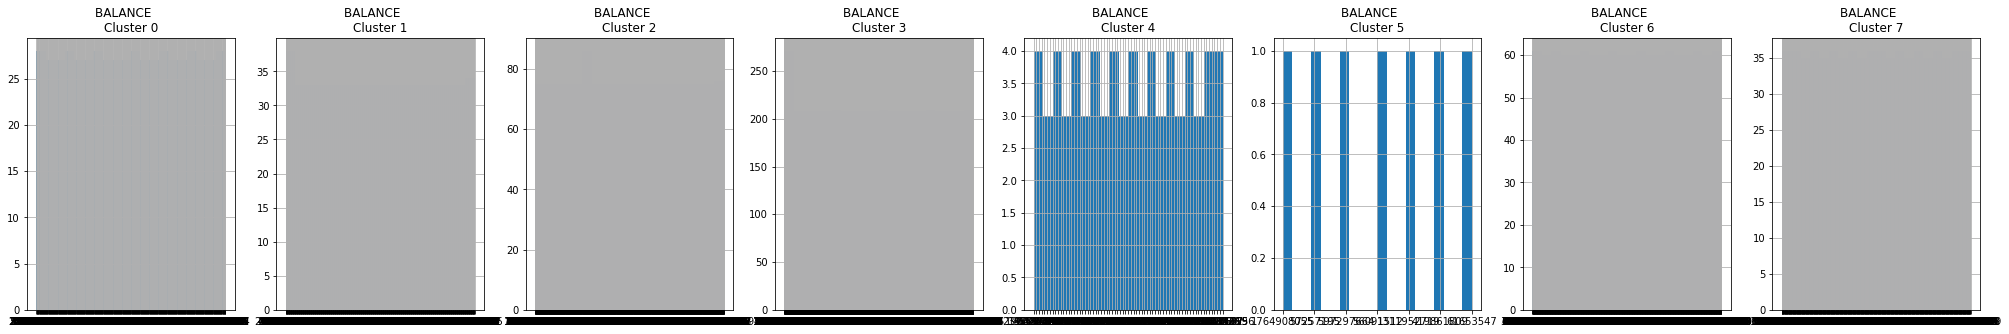

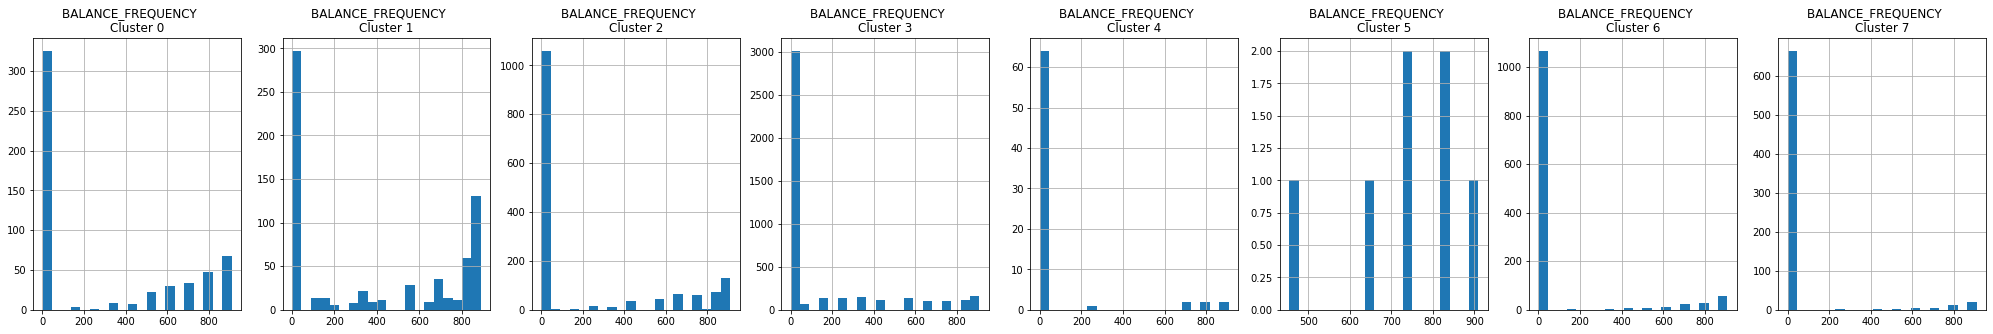

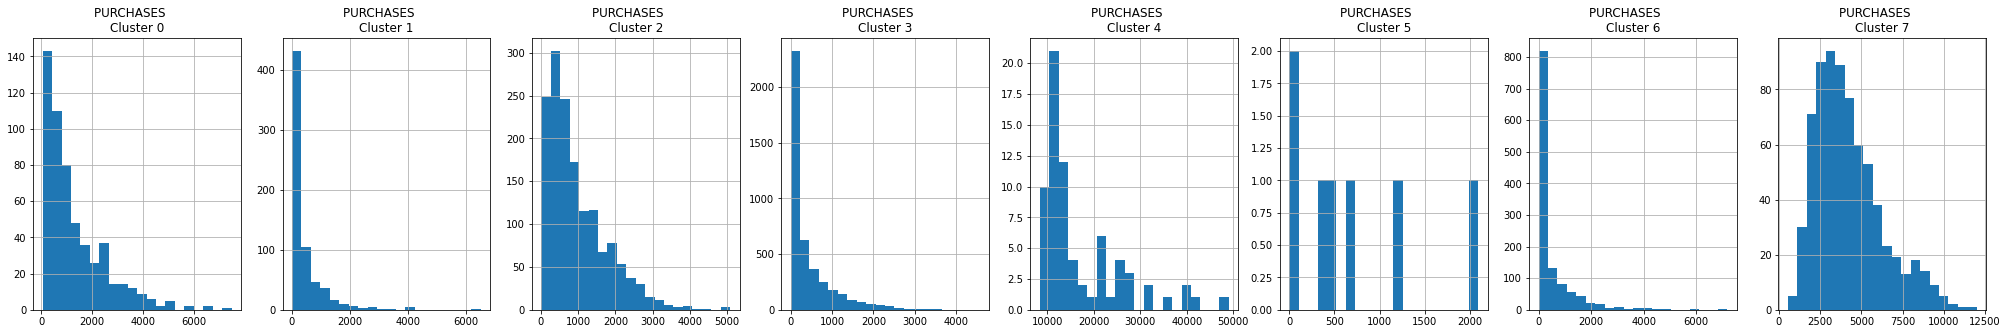

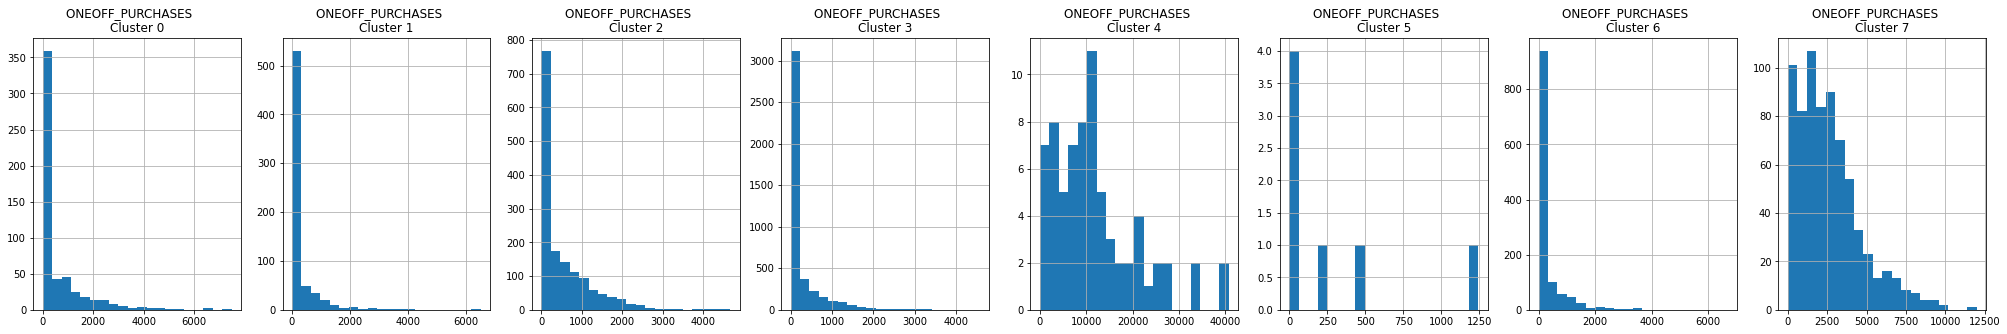

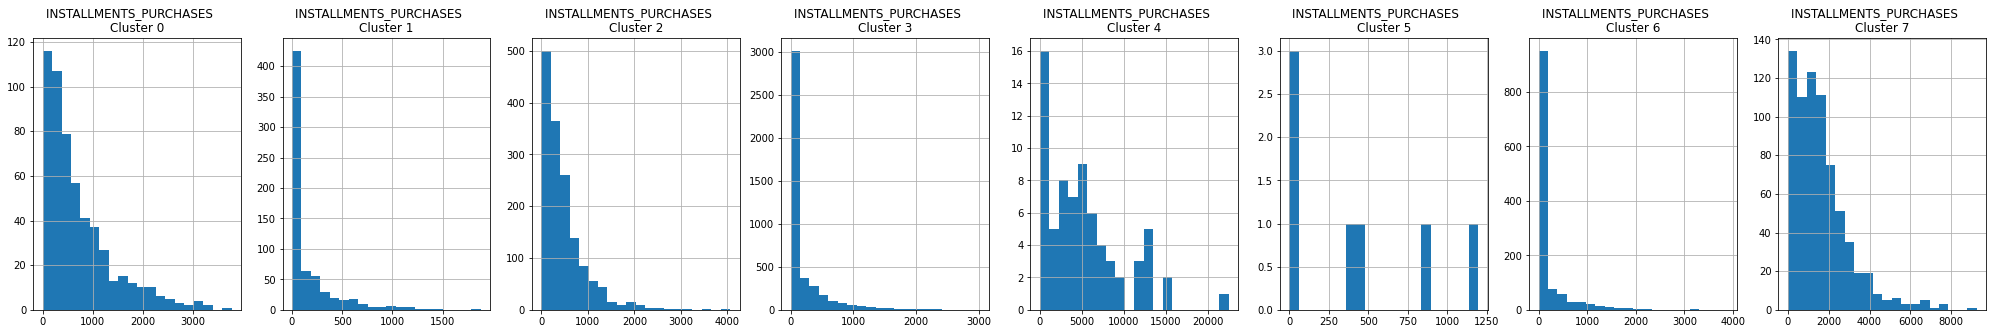

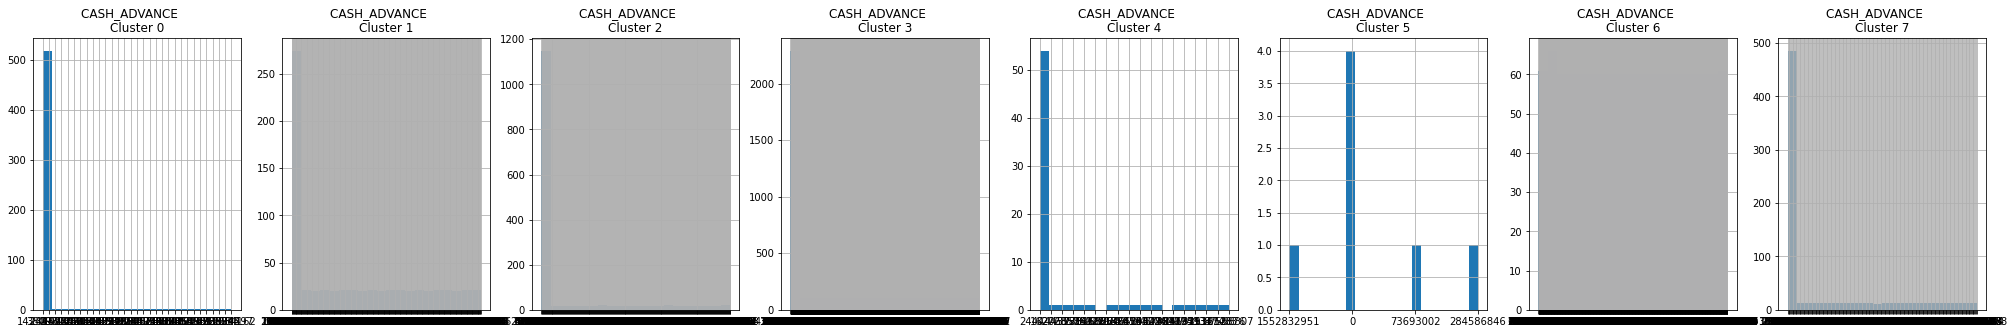

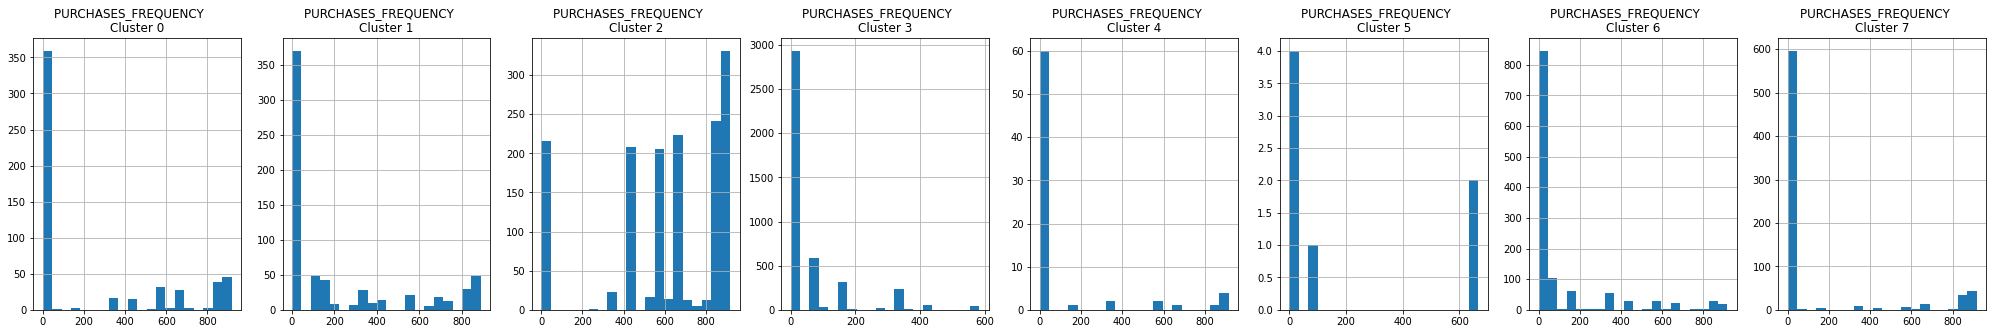

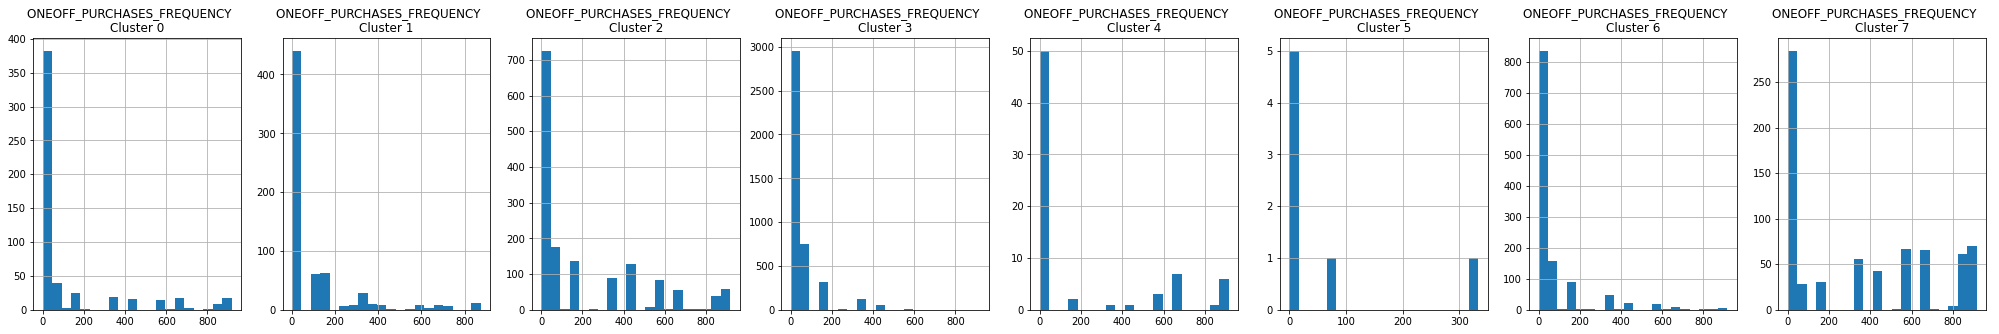

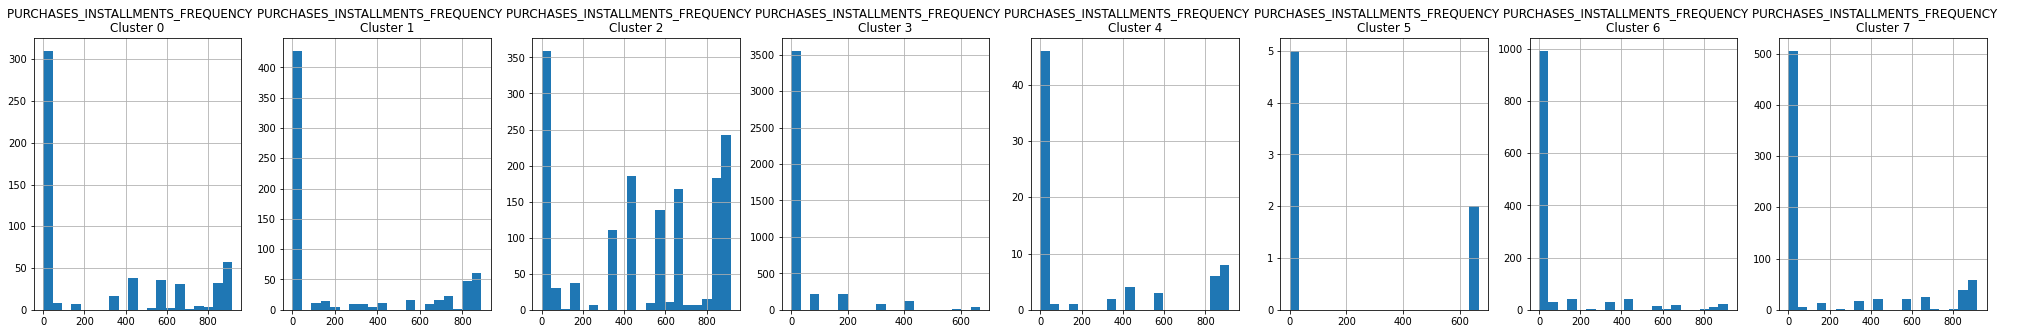

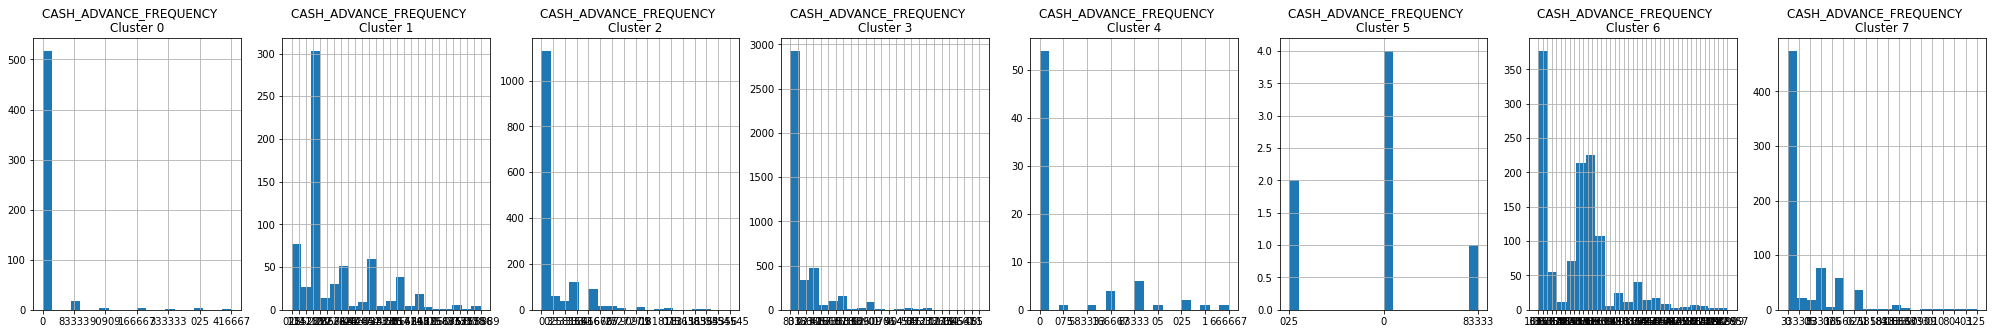

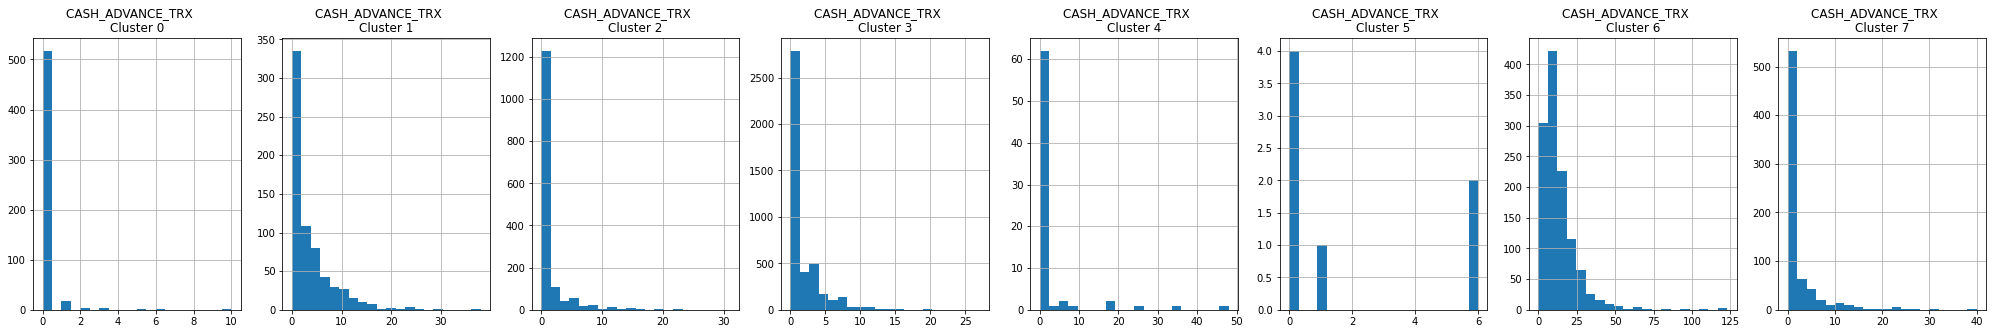

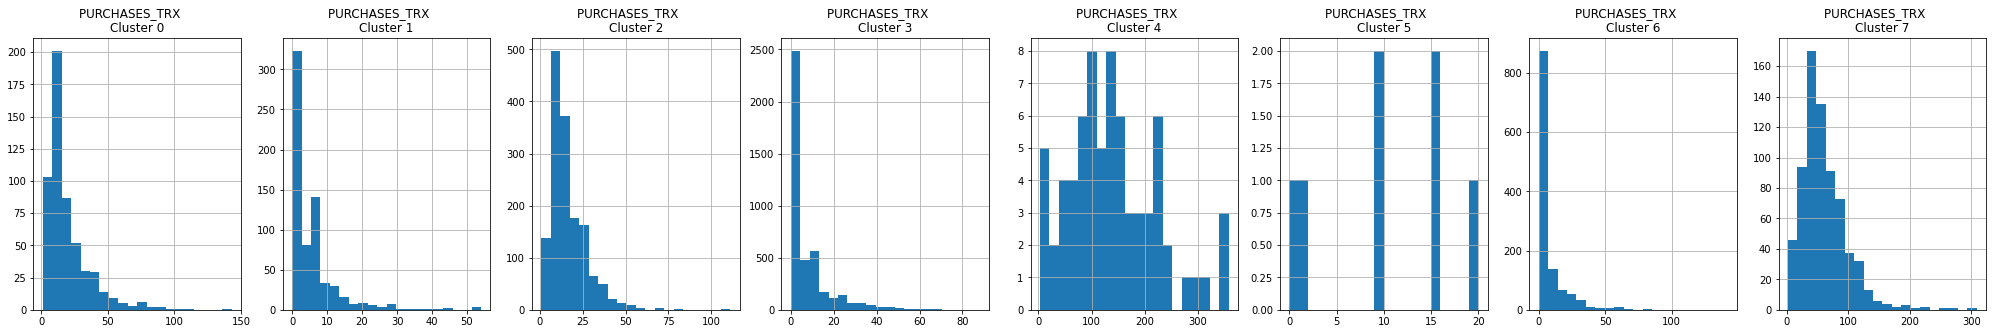

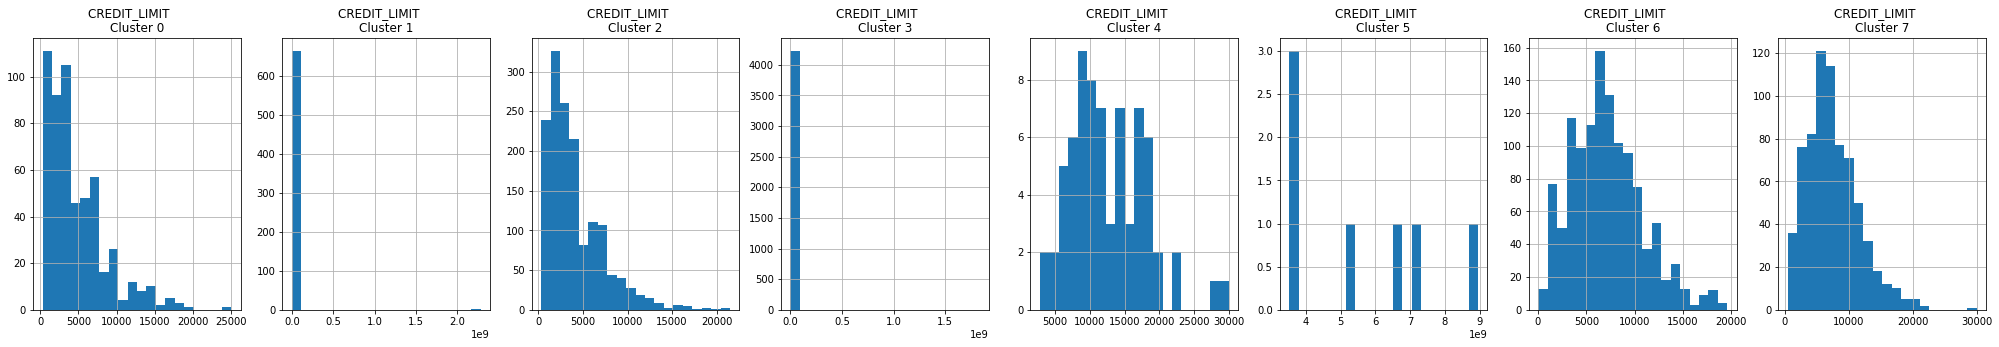

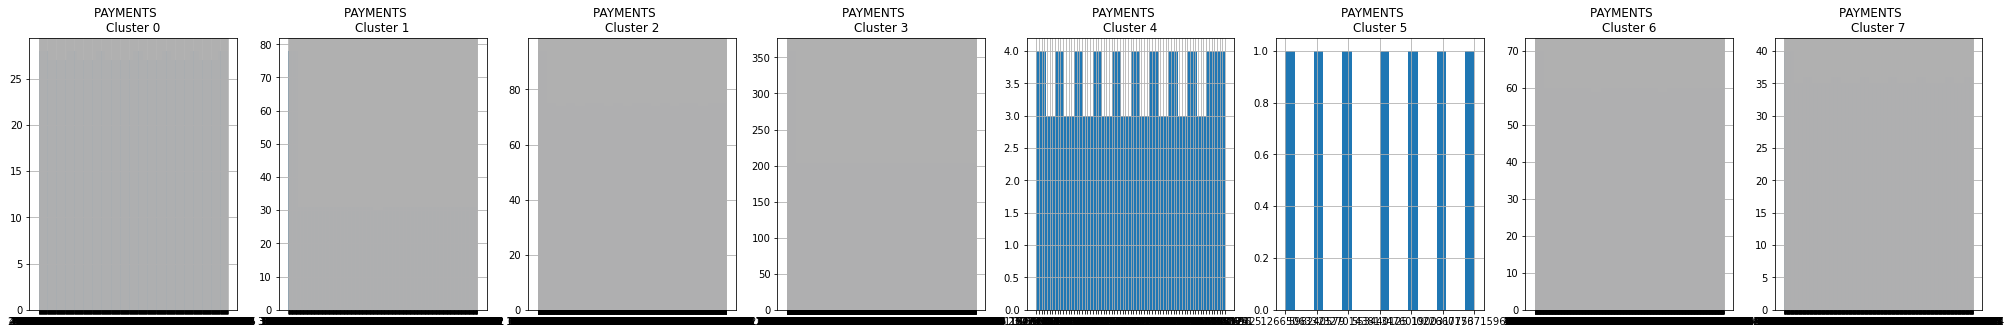

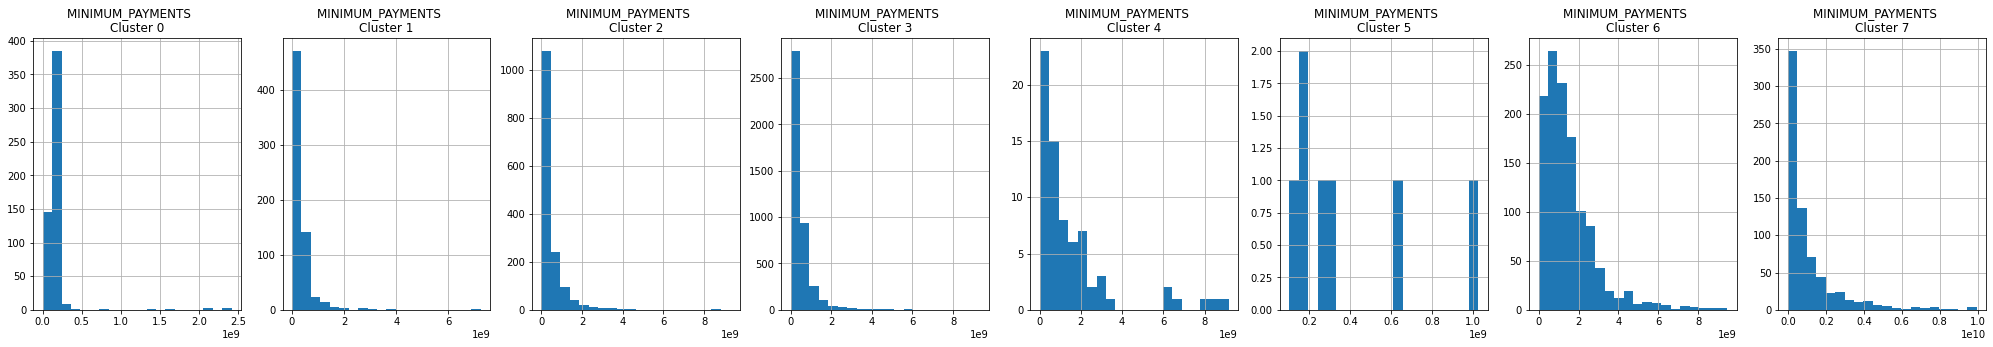

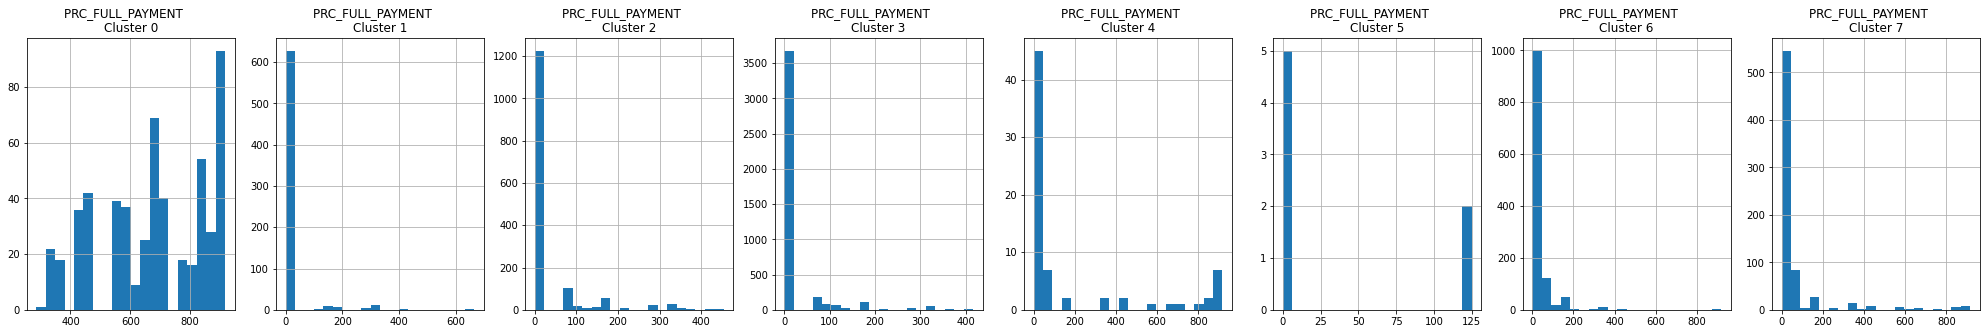

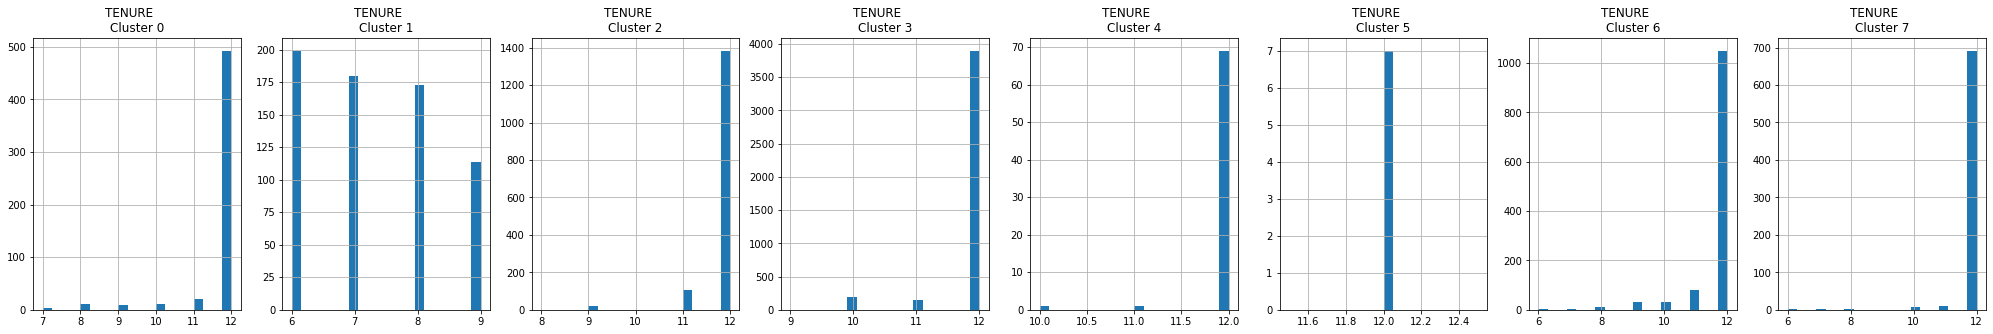

In [ ]:
#visualizamos cada cluster en histogramas
for i in df_banco.columns: #recorre columnas
  plt.figure(figsize=(35,5)) 
  for j in range(8): #para cada columna recorre los elementos de la columna cluster, y cuando el calor de la celda en la columna cluster es igual a j, la dibuja
    plt.subplot(1,8,j+1)
    cluster=df_banco_cluster[df_banco_cluster['Cluster']==j]
    cluster[i].hist(bins=20)
    plt.title('{}    \nCluster {}'.format(i, j))
  plt.show()

## **APLICAR ANÁLISIS DE LAS COMPONENTES PRINCIPALES Y VISUALIZAR LOS RESULTADOS. Una convolución usando algoritmo PCA (reduccion de elemntos a componentes principales)**

Esto se hace porque no podriamos graficar un cluster de 17 dimensiones, entonces con esta convolucion tipo pca lo reducimos a 2 dimensiones posibles de graficar y con esquemas de colores resaltamos los segmentos

In [ ]:
pca=PCA(n_components=2)
principal_comp=pca.fit_transform(df_banco_scaler)
principal_comp #Este array serian las componentes principales asociadas al dataframe origianl. Puntualmente 2 columnas de componentes principales

array([[-1.30329844, -1.41364103],
       [-0.63236815,  2.21651754],
       [-0.37458165, -0.13730728],
       ...,
       [-1.3233765 , -2.12586228],
       [-2.0394117 , -0.85919244],
       [-0.21324873, -0.72595813]])

In [ ]:
pca_df=pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])

In [ ]:
pca_df.head(10)

,pca1,pca2
0,-1.303298,-1.413641
1,-0.632368,2.216518
2,-0.374582,-0.137307
3,-0.467338,-0.431928
4,-0.989593,-0.686891
5,0.534221,-0.421510
6,4.588160,-0.165202
7,-0.568866,-0.497565
8,-0.374952,-0.755415
9,-0.338041,-1.151703


In [ ]:
# Concatenamos las etiquetas de los clusters con el dataframe de las componentes principales

pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':label})], axis = 1)

pca_df.head()

,pca1,pca2,cluster
0,-1.303298,-1.413641,3
1,-0.632368,2.216518,6
2,-0.374582,-0.137307,3
3,-0.467338,-0.431928,3
4,-0.989593,-0.686891,3


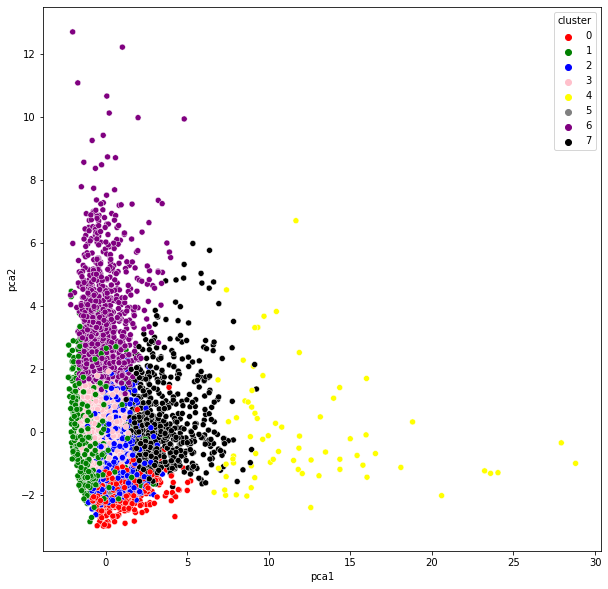

In [ ]:
#Graficamos el cluster ahora que tenemos las componentes principales y sus label
plt.figure(figsize=(10,10))
ax=sns.scatterplot(x="pca1", y="pca2",hue="cluster", data=pca_df, palette=["red", "green", "blue", "pink", "yellow", "gray", "purple", "black"])
plt.show()

**APLICAR LOS AUTOENCODERS (REDUCIR LA DIMENSIÓN DE LOS DATOS CON LOS AUTOENCODERS)**

In [ ]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
#from keras.optimizers import SGD

encoding_dim = 7

input_df = Input(shape = (17, ))

# Glorot normal inicializador (Xavier normal initializer) tomar muestras aleatorias de una distribución normal truncada

x = Dense(encoding_dim, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x) 
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x) 
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x) 

encoded = Dense(10, activation = 'relu', kernel_initializer = 'glorot_uniform')(x) 

x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded) 
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x) 

decoded = Dense(17, kernel_initializer = 'glorot_uniform')(x)


autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
df_banco_scaler.shape

(8950, 17)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 7)                 126       
                                                                 
 dense_1 (Dense)             (None, 500)               4000      
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 2000)              1002000   
                                                                 
 dense_4 (Dense)             (None, 10)                20010     
                                                                 
 dense_5 (Dense)             (None, 2000)              22000 

In [ ]:
autoencoder.fit(df_banco_scaler, df_banco_scaler, batch_size=128, epochs = 25, verbose = 1) #entrada y salida mismo set de datos

Epoch 1/25
70/70 [==============================] - 5s 60ms/step - loss: 0.6381
Epoch 2/25
70/70 [==============================] - 4s 59ms/step - loss: 0.3995
Epoch 3/25
70/70 [==============================] - 4s 60ms/step - loss: 0.3217
Epoch 4/25
70/70 [==============================] - 4s 60ms/step - loss: 0.2906
Epoch 5/25
70/70 [==============================] - 4s 60ms/step - loss: 0.2689
Epoch 6/25
70/70 [==============================] - 4s 59ms/step - loss: 0.2620
Epoch 7/25
70/70 [==============================] - 4s 59ms/step - loss: 0.2396
Epoch 8/25
70/70 [==============================] - 4s 59ms/step - loss: 0.2808
Epoch 9/25
70/70 [==============================] - 4s 59ms/step - loss: 0.2370
Epoch 10/25
70/70 [==============================] - 4s 60ms/step - loss: 0.1859
Epoch 11/25
70/70 [==============================] - 4s 59ms/step - loss: 0.1797
Epoch 12/25
70/70 [==============================] - 4s 59ms/step - loss: 0.1729
Epoch 13/25
70/70 [==================

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [ ]:
pred = encoder.predict(df_banco_scaler) #Hasta lo que hizo fue aplciar toda una etapa previa de reduccion a traves de función sigmoidea para luego aplicar kmeas como se hizo en la etapa anterior
pred.shape

(8950, 10)

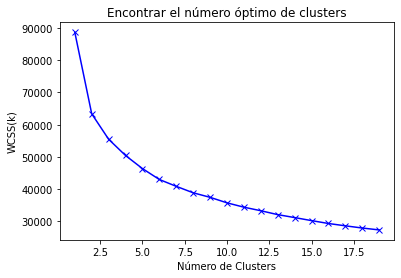

In [ ]:
scores_2 = []

range_values = range(1,20)

for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    scores_2.append(kmeans.inertia_)


plt.plot(range_values, scores_2, 'bx-')
plt.title("Encontrar el número óptimo de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS(k)")
plt.show()

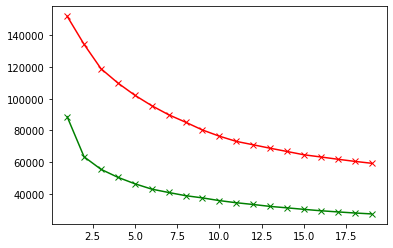

In [ ]:
plt.plot(range_values, scores_1, 'bx-', color = "r")
plt.plot(range_values, scores_2, 'bx-', color = "g")

In [ ]:
df_cluster_dr = pd.concat([df_banco, pd.DataFrame({'cluster': label})], axis = 1)
df_cluster_dr.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40900749,818.182,95.40,0.00,95.4,0,166.667,0.000,83.333,0,0,2,1000.0,201802084,1.395098e+08,0.000,12,3
1,3202467416,909.091,0.00,0.00,0.0,6442945483,0.000,0.000,0.000,025,4,0,7000.0,4103032597,1.072340e+09,222.222,12,6
2,2495148862,1.000,773.17,773.17,0.0,0,1.000,1.000,0.000,0,0,12,7500.0,622066742,6.272848e+08,0.000,12,3
3,1666670542,636.364,1499.00,1499.00,0.0,205788017,83.333,83.333,0.000,83333,1,1,7500.0,0,6.211902e+08,0.000,12,3
4,817714335,1.000,16.00,16.00,0.0,0,83.333,83.333,0.000,0,0,1,1200.0,678334763,2.447912e+08,0.000,12,3


In [ ]:
kmeans = KMeans(4)
kmeans.fit(pred)
label = kmeans.labels_
y_kmeans = kmeans.fit_predict(pred)

In [ ]:
pca = PCA(n_components=2)
princ_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = princ_comp, columns=["pca1", "pca2"])
pca_df.head()

,pca1,pca2
0,-1.713523,0.201386
1,2.622049,-1.369372
2,-0.580439,0.053424
3,-1.001867,-0.005988
4,-1.563686,-0.068064


In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({"cluster":label})], axis = 1)
pca_df

,pca1,pca2,cluster
0,-1.713523,0.201386,0
1,2.622049,-1.369372,2
2,-0.580439,0.053424,0
3,-1.001867,-0.005988,0
4,-1.563686,-0.068064,0
...,...,...,...
8945,0.263778,-0.207318,3
8946,0.546510,-0.305409,3
8947,-0.214778,0.339017,3
8948,0.021154,-0.527452,3


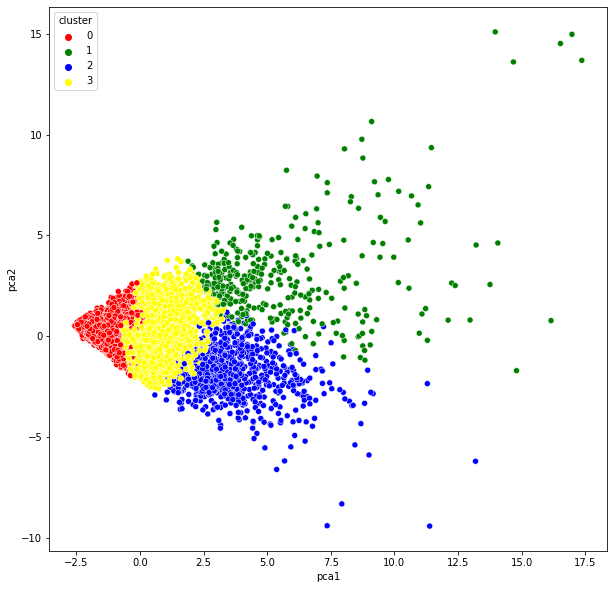

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y = "pca2", hue="cluster", data = pca_df, palette=["red", "green", "blue", "yellow"])
plt.show()